# Imminent ICU Admission and Prolonged Stay Prediction using Gradient Boosting Machines

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm

from utils.splits import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir/gbm'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime',
  'chartinterval'],
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'dates': ['charttime', 'intime'],
 'modeldir': PosixPath('../data/workdir/gbm/models'),
 'min_freq': 3,
 'ia_thresh': 0.435,
 'ps_thresh': 0.324,
 'start_seed': 127}

## GBM Dev

In [3]:
seed = 643
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = ori_df.loc[(ori_df['chartinterval'] != 0)][args.prolonged_stay_cols].reset_index(drop=True)

print(ia_df.shape)
print(ps_df.shape)

(50809, 3)
(60830, 3)


### Imminent ICU Admission

In [4]:
df = set_group_splits(ia_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), binary=True, max_features=60_000)

In [5]:
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50809, 4), (42683, 60000), (8126, 60000), (42683,), (8126,))

In [6]:
params = {
  "objective": "binary",
  "metric": "binary_logloss",
  "bagging_fraction": 0.5,
  "bagging_freq": 5,
  "boosting": "dart",
  "feature_fraction": 0.5,
  "is_unbalance": True,
  "learning_rate": 0.1,
  "min_data_in_leaf": 3,
  "num_iterations": 150,
  "num_leaves": 50,
}

In [7]:
clf = lightgbm.LGBMClassifier(**params, n_threads=32)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

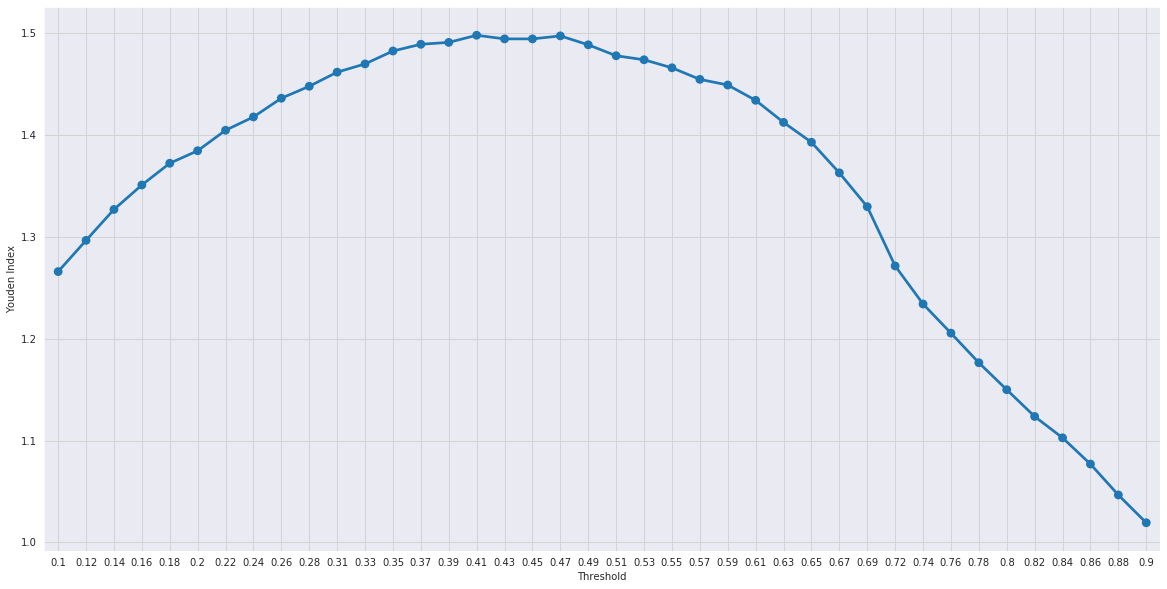

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

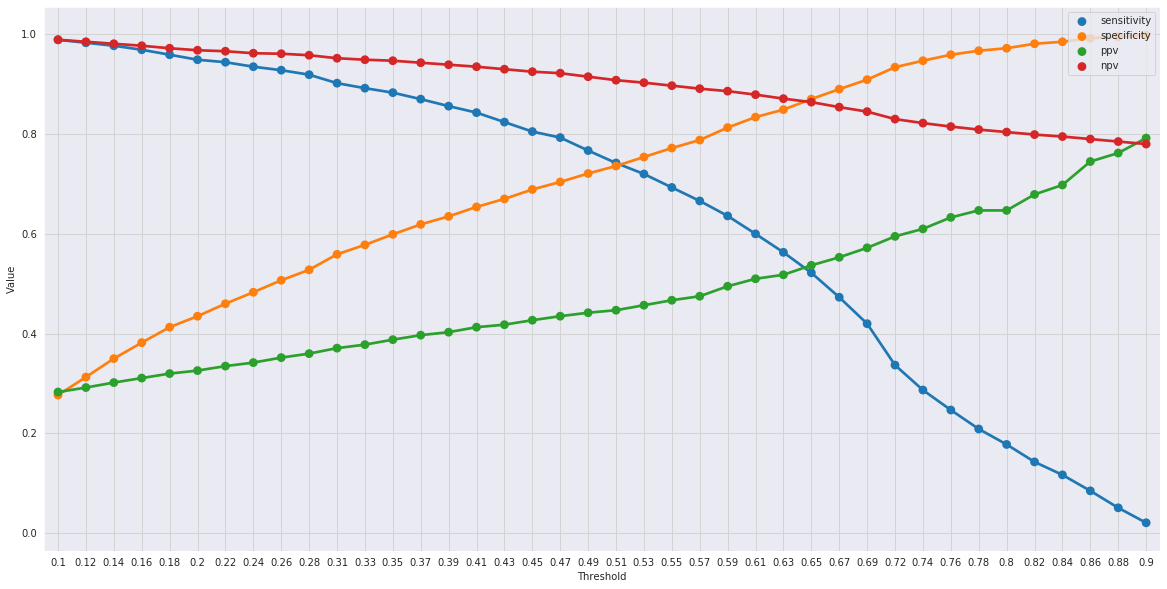

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.9, 40)

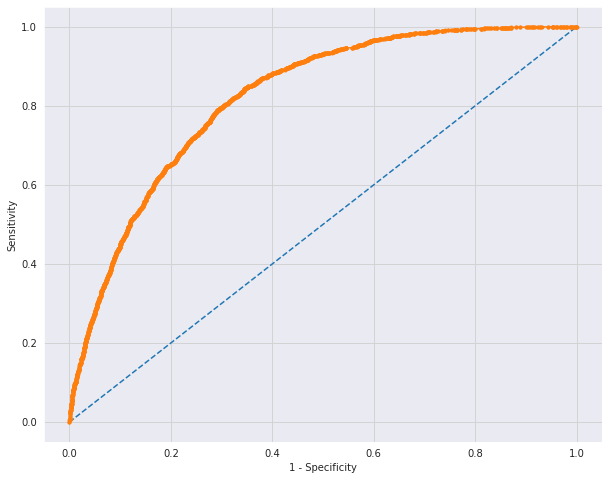

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [11]:
threshold = 0.42
y_pred = (prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.832
specificity,0.662
ppv,0.415
npv,0.932
f1,0.554
auroc,0.821


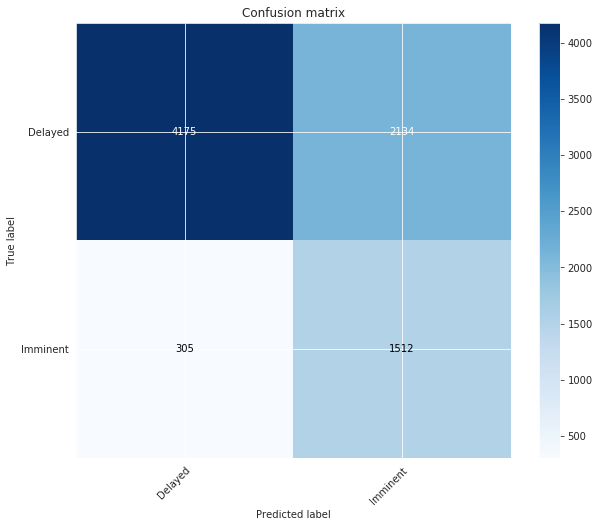

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

In [ ]:
import re
from spacy.lang.en.stop_words import STOP_WORDS

def get_top_markers(feature_names, scores, n_markers=50):
  p = re.compile('^[a-z\s]+$')
  sorted_idxs = np.argsort(scores)
  markers = []
  wts = []

  for i in sorted_idxs:
    marker = feature_names[i]
    if len(marker) > 7 and marker not in STOP_WORDS and p.match(marker):
      markers.append(marker)
      wts.append(scores[i])

  wts = np.asarray(wts)
  df = pd.DataFrame({'markers': markers, 'score': wts/wts.sum()}, columns=['markers', 'score'])
  
  return df.head(n_markers), df.tail(n_markers).sort_values(by='score').reset_index(drop=True)

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 15))
# sns.barplot(x='score', y='markers', data=pos_df, color='b', ax=ax[0])
# sns.barplot(x='score', y='markers', data=neg_df, color='b', ax=ax[1])
# ax[0].set_xlabel('')
# ax[1].set_xlabel('')
# ax[1].set_ylabel('')

# plt.subplots_adjust(wspace = 0.3)
# fig.text(0.5, 0.1, 'Score', ha='center')

In [ ]:
# scores = clf.feature_importances_ / clf.feature_importances_.sum()

# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
# ax[0].imshow(neg_cloud)
# ax[0].axis('off')
# ax[0].set_title('Delayed')
# ax[1].imshow(pos_cloud)
# ax[1].axis('off')
# ax[1].set_title('Imminent')

### Prolonged ICU Stay

In [13]:
df = set_group_splits(ps_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), binary=True, max_features=60_000)

In [14]:
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60830, 4), (51844, 60000), (8986, 60000), (51844,), (8986,))

In [15]:
params = {
  "objective": "binary",
  "metric": "binary_logloss",
  "is_unbalance": True,
  "bagging_fraction": 0.7,
  "bagging_freq": 6,
  "boosting": "gbdt",
  "feature_fraction": 0.5,
  "learning_rate": 0.25,
  "min_data_in_leaf": 5,
  "num_iterations": 172,
}

In [16]:
clf = lightgbm.LGBMClassifier(**params, n_threads=32)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

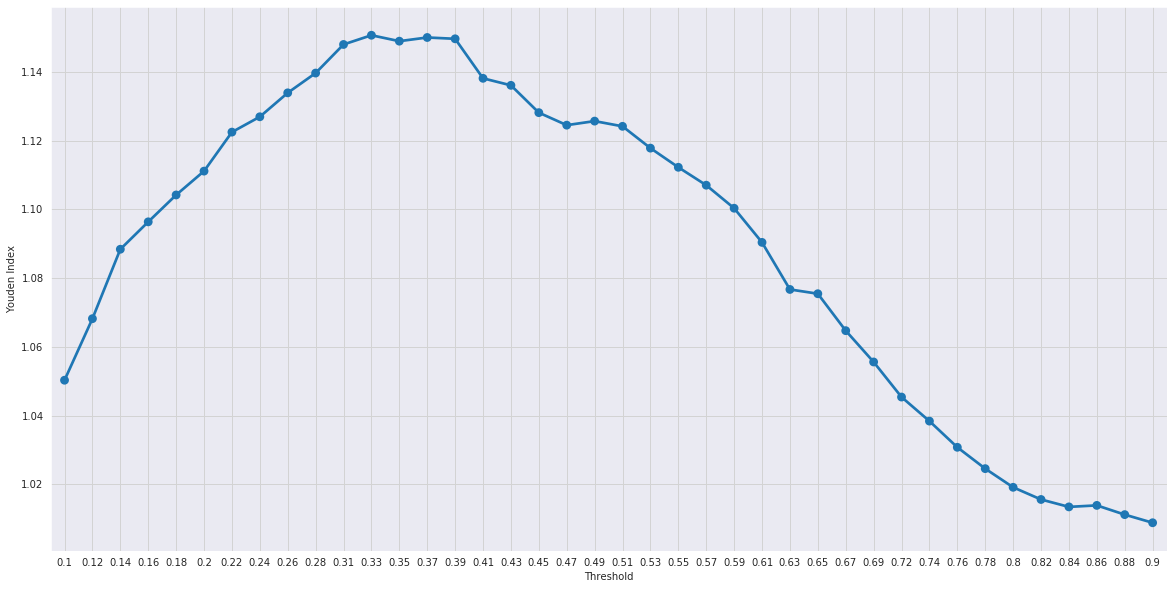

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

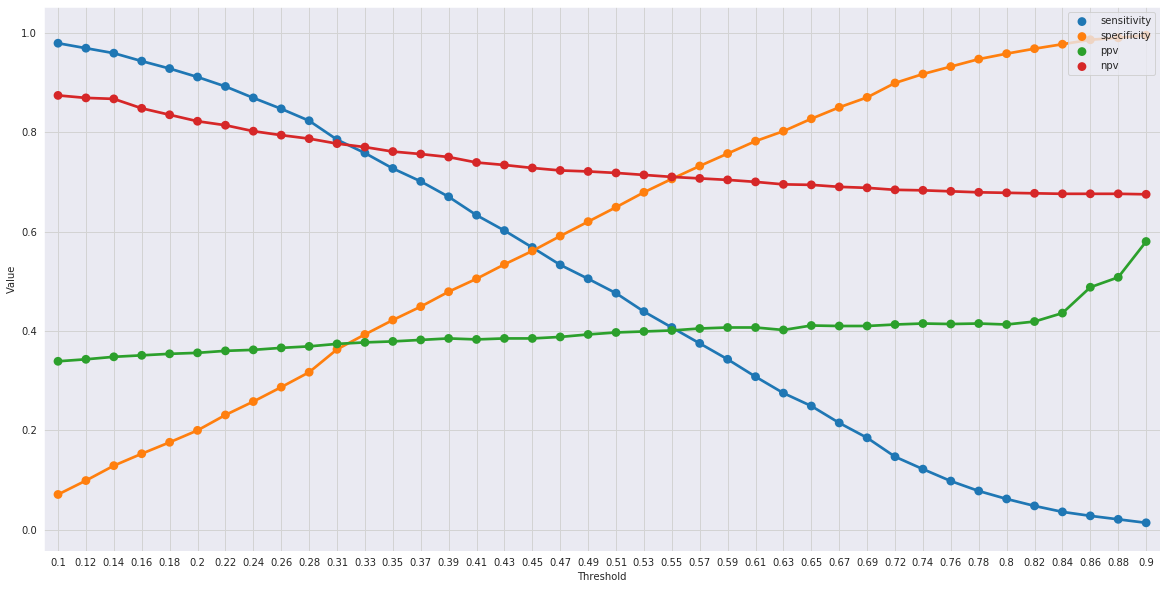

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.9, 40)

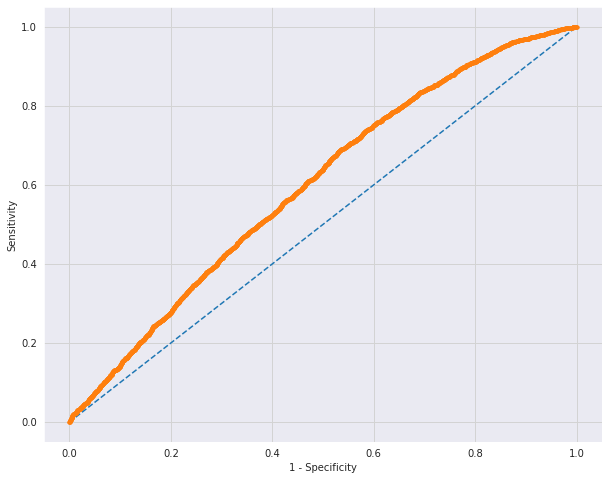

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [24]:
threshold = 0.34
y_pred = (prob > threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.742
specificity,0.408
ppv,0.378
npv,0.765
f1,0.501
auroc,0.599


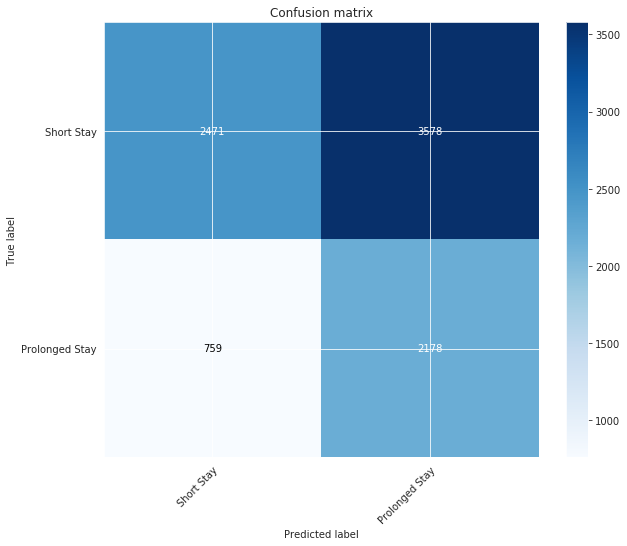

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Short Stay', 'Prolonged Stay'], normalize=False, title='Confusion matrix')

In [ ]:
# scores = clf.feature_importances_ / clf.feature_importances_.sum()

# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.feature_importances_/clf.feature_importances_.sum(), n_words=50)
# ax[0].imshow(neg_cloud)
# ax[0].axis('off')
# ax[0].set_title('Negative Class')
# ax[1].imshow(pos_cloud)
# ax[1].axis('off')
# ax[1].set_title('Positive Class')

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

### Imminent ICU Admission

In [ ]:
with open(args.workdir/f'imminent_adm_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'imminent_adm_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

### Prolonged ICU Stay

In [ ]:
with open(args.workdir/f'prolonged_stay_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'prolonged_stay_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=False, title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=True, title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Run

In [ ]:
seed = 643
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ori_df['relative_charttime'] = (ori_df['charttime'] - ori_df['intime'])

ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols + ['relative_charttime']].reset_index(drop=True)

ps_df = ori_df.loc[(ori_df['chartinterval'] != 0)][args.prolonged_stay_cols + ['relative_charttime']].reset_index(drop=True)

In [ ]:
interval_hours = 12
starting_day = -20
ending_day = -1

### Imminent ICU Admission

In [ ]:
df = set_group_splits(ia_df.copy(), pct=0.25, group_col='hadm_id', seed=seed)
df['prob'] = -1

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
from args import ia_params
clf = lightgbm.LGBMClassifier(**ia_params)

clf.fit(x_train, y_train)
df.loc[(df['split'] == 'test'), 'prob'] = clf.predict_proba(x_test)[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df.loc[(df['split'] == 'test')], args.ia_thresh, starting_day, ending_day, interval_hours)

In [ ]:
scores = clf.feature_importances_ / clf.feature_importances_.sum()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.feature_importances_, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

### Prolonged ICU Stay

In [ ]:
df = set_group_splits(ps_df.copy(), pct=0.25, group_col='hadm_id', seed=seed)
df['prob'] = -1

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
from args import ps_params
clf = lightgbm.LGBMClassifier(**ps_params)

clf.fit(x_train, y_train)
df.loc[(df['split'] == 'test'), 'prob'] = clf.predict_proba(x_test)[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df.loc[(df['split'] == 'test')], args.ps_thresh, starting_day, ending_day, interval_hours)

In [ ]:
scores = clf.feature_importances_ / clf.feature_importances_.sum()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.feature_importances_, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')